In [20]:
import pandas as pd
import numpy as np
from collections import Counter

import statsmodels.api as sm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy

import scipy.stats
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import seaborn as sns

In [21]:
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import datasets
from sklearn.cluster import KMeans

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('video_clean.csv', index_col = 0)

=====================================================================================================================
# Question 1. How to predict the future views? 

## - Question Description: 

The major concern for Youtubers is the number of viewers. The more viewers the more attention, which means more profit gained from YouTube. In the matter of covering news or telling stories about Coronavirus, it is important to figure out what topics people do actually care about？

## - Model: Linear Regression


In [ ]:
# Count the word frequencies in titles.

words = []
df['words'] = df.clean_text.copy()
for i in range(df.shape[0]):
    words = words + df.clean_text[i].split()
    df.words[i] = df.clean_text[i].split()
word_freq = Counter(words).most_common()
#Create dummy variables for words with top 40 frequencies
for k in range(40):
    df[word_freq[k][0]] = df.clean_text.copy()

for i in range(df.shape[0]):
    for k in range(40):
        if word_freq[k][0] in df['words'][i]: df[word_freq[k][0]][i] = 1
        else: df[word_freq[k][0]][i] = 0

### We first plot the histogram of the numbers of views.

In [ ]:
plt.hist(df['view'], bins='auto', alpha=0.7, rwidth=0.85)[2]

### Since it's heavily skewed, we apply a log transformation to it.

In [ ]:
df['view_log'] = np.log(df['view'])
plt.hist(df['view_log'], bins='auto', alpha=0.7, rwidth=0.85)[2]

### Regression.

In [ ]:
df2 = pd.concat([df.uploadtime, df.length, df.subscriber, df.iloc[:,11:51]], axis=1)
X = df2; Y = df['view_log']; X = sm.add_constant(X); X = X.astype(float)
model = sm.OLS(Y, X).fit()
#predictions = model.predict(X)
model.summary()

## Answer and analysis: 
-As we see from the above results, the prediction for future views by linear regression model would be highly problematic and demonstrate lack-of-fit since the R square is only around 0.25. The relationship between the views and One-Hot-Encoded text may not be exactly linear. 

-Based on current model, only subscriber and upload time remain significant, which is reasonable. If a channel has larger number of subscribers and the video has indeed been uploaded for a longer time the expected number of viewers should be higher intuitively.

=====================================================================================================================


=====================================================================================================================
# Question 2. PCA

## - Question Description: 

## - Model: PCA

In [ ]:
#PCA
pca = PCA(n_components = 'mle')
X_reduced = pca.fit_transform(X)
X_reduced.shape
#Perform 10-fold cross-validation to see how PCR influences MSE.
n = len(X_reduced)
fold = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)

model2 = LinearRegression(); mse = []    
mse.append(-model_selection.cross_val_score(model2, np.ones((n,1)), Y.ravel(), cv=fold, scoring='neg_mean_squared_error').mean())

for i in np.arange(1, 44):
    mse.append(-model_selection.cross_val_score(model2, X_reduced[:,:i], Y.ravel(), cv=fold, scoring='neg_mean_squared_error').mean())

In [ ]:
plt.plot(mse)
plt.xlabel('Number of Principal Components')
plt.ylabel('MSE')
plt.plot(3, mse[3], 'o', color = 'r')

### It's reasonable to choose n_components = 3.

In [ ]:
pca = PCA(n_components = 3)
X_pca = pca.fit_transform(X)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2])

## Answer and analysis: 
-

-

=====================================================================================================================


=====================================================================================================================
# Question 3. If we can determine this video will be likeable 

## - Question Description: 

Based current data, we want to know what kind of videos with certain features will become popular among the audience. It should also be a recommendation system problem, meaning that pushing what kinds of videos to the users tend to get positive feedback.

## - Model: Naive Bayes Text Classification
    
Here we defined a video as likeable by creating a binary classifier in two different ways. Firstly, by the method of odds ratios, when like/dislike ratio > a threshold, we classify it as 1 otherwise, 0. Secondly, by the method of log(mean), when log(mean) > a threshold, we classify it as 1 otherwise, 0. The choice of threshold should balance the data so the possible options are mean or median.



In [ ]:
### The text here includes titles and channel names.
seed=2020
np.random.seed(seed)
df['all_text'] = df['clean_text'] + ' '+ df['channel']

### Approach 1. When like/dislike ratio > median, we classify this article as 1; otherwise, 0.

In [ ]:
df['ratio'] = df['like']/df['dislike']
np.median(df['ratio'][np.isfinite(df['ratio'])])

In [ ]:
df['classifier'] = df['ratio'].copy()
for i in range(df.shape[0]):
    if df['ratio'][i] > 12: df['classifier'][i] = 1
    else: df['classifier'][i] = 0

### Split the titles and classifiers into a training and test set using a 20% test split

In [ ]:
texts_all = df['all_text'].values
labels_all = df['classifier'].values
train_texts, test_texts, train_labels, test_labels = train_test_split(texts_all, labels_all, test_size=0.2)
### Create `count`, `set` and `Tfidf` features using `CountVectorizer` and `TfidfVectorizer`.

count0 = CountVectorizer(input='content')
count1 = count0.fit_transform(train_texts)
count2 = count0.transform(test_texts)

set0 = CountVectorizer(input='content', binary=True)
set1 = set0.fit_transform(train_texts)
set2 = set0.transform(test_texts)

Tfidf0 = TfidfVectorizer(input='content')
Tfidf1 = Tfidf0.fit_transform(train_texts)
Tfidf2 = Tfidf0.transform(test_texts)

### Fit a `MultinomialNB` with smoothing $\alpha=1$ to the count features.

In [ ]:
m0 = MultinomialNB(1)
m0.fit(count1, train_labels)
print('The predicition accuracy in the training set is:', np.mean(m0.predict(count1)==train_labels))

### Use K-Fold validation with K=10 to select between multinomial Naive Bayes classifiers trained to either `set`, `count` and `tfidf` featues.

In [ ]:
def model_cross_validation(model,X,y,folds):
    kfolds=len(folds)
    train_performance=np.empty(kfolds)
    validation_performance=np.empty(kfolds)
    for idx in range(kfolds):
        train,validation=folds[idx]
        X_train=X[train]
        y_train=y[train]
        model.fit(X_train,y_train)
        train_accuracy=np.average(model.predict(X_train)==y_train)
        X_validation=X[validation]
        y_validation=y[validation]
        validation_accuracy=np.average(model.predict(X_validation)==y_validation)
        train_performance[idx]=train_accuracy
        validation_performance[idx]=validation_accuracy
    return np.array(train_performance),np.array(validation_performance)

kf=KFold(10,shuffle=True)
folds=list(kf.split(set1))

In [ ]:
t1, v1 = model_cross_validation(m0, set1, train_labels, folds)
# The accuracy of set features:
print("Train: ", np.mean(t1), "; Validation: ", np.mean(v1))

In [ ]:
t2, v2 = model_cross_validation(m0, count1, train_labels, folds)
# The accuracy of count features:
print("Train: ", np.mean(t2), "; Validation: ", np.mean(v2))

In [ ]:
t3, v3 = model_cross_validation(m0, Tfidf1, train_labels, folds)
# The accuracy of tfdif features:
print("Train: ", np.mean(t3), "; Validation: ", np.mean(v3))

### The count features have the best accuracy.

### Therefore, we fit the best model to all the training data and compute its accuracy on the test set.

In [ ]:
m0.fit(count1, train_labels)
print('The accuracy on the test set is:', np.mean(m0.predict(count2)==test_labels))

### Approach 2. When log(view) > mean, we classify this article as 1; otherwise, 0.

In [ ]:
np.median(df['view_log'][np.isfinite(df['view_log'])])

In [ ]:
df['classifier2'] = df['view_log'].copy()
for i in range(df.shape[0]):
    if df['view_log'][i] > 12.84: df['classifier2'][i] = 1
    else: df['classifier2'][i] = 0

### Split the titles and classifiers into a training and test set using a 20% test split

In [ ]:
texts_all = df['all_text'].values
labels2_all = df['classifier2'].values
train_texts, test_texts, train_labels2, test_labels2 = train_test_split(texts_all, labels2_all, test_size=0.2)

### Create `count`, `set` and `Tfidf` features using `CountVectorizer` and `TfidfVectorizer`.

In [ ]:
count0_2 = CountVectorizer(input='content')
count1_2 = count0.fit_transform(train_texts)
count2_2 = count0.transform(test_texts)

set0_2 = CountVectorizer(input='content', binary=True)
set1_2 = set0.fit_transform(train_texts)
set2_2 = set0.transform(test_texts)

Tfidf0_2 = TfidfVectorizer(input='content')
Tfidf1_2 = Tfidf0.fit_transform(train_texts)
Tfidf2_2 = Tfidf0.transform(test_texts)

### Fit a `MultinomialNB` with smoothing $\alpha=1$ to the count features.

In [ ]:
m1 = MultinomialNB(1)
m1.fit(count1_2, train_labels2)
print('The predicition accuracy in the training set is:', np.mean(m1.predict(count1_2)==train_labels2))

### Use K-Fold validation with K=10 to select between multinomial Naive Bayes classifiers trained to either `set`, `count` and `tfidf` featues.

In [ ]:
kf=KFold(10,shuffle=True)
folds=list(kf.split(set1_2))

In [ ]:
t1_2, v1_2 = model_cross_validation(m1, set1_2, train_labels2, folds)
# The accuracy of set features:
print("Train: ", np.mean(t1_2), "; Validation: ", np.mean(v1_2))

In [ ]:
t2_2, v2_2 = model_cross_validation(m1, count1_2, train_labels2, folds)
# The accuracy of count features:
print("Train: ", np.mean(t2_2), "; Validation: ", np.mean(v2_2))

In [ ]:
t3_2, v3_2 = model_cross_validation(m1, Tfidf1_2, train_labels2, folds)
# The accuracy of tfdif features:
print("Train: ", np.mean(t3_2), "; Validation: ", np.mean(v3_2))

### Therefore, we fit the best model to all the training data and compute its accuracy on the test set.

In [ ]:
m1.fit(count1_2, train_labels2)
print('The accuracy on the test set is:', np.mean(m1.predict(count2_2)==test_labels2))

# Question 4. What is the possible distribution of video length?

## - Question Description: 

For a specific user, we are interested in the possible distribution of the length of the video

## - Model: 

Distribution fitting, test on goodness-of-fit and comparisons of QQ plot 


In [ ]:
from sklearn import datasets
df = pd.read_csv('video_clean.csv', index_col = 0)
y=df['length']
#removing outliers 
y = [a for a in y if a<3000]
y = np.array(y)
x = np.arange(len(y))
size = len(y)
#standardize 
sc=StandardScaler() 
yy = y.reshape(-1,1)
sc.fit(yy)
y_std =sc.transform(yy)
y_std = y_std.flatten()
y_std
del yy
import warnings
warnings.filterwarnings("ignore")
dist_names = ['beta','expon','gamma','lognorm','norm','pearson3','triang','uniform',
              'weibull_min',  'weibull_max','cauchy','invgamma','t']
chi_square = []
p_values = []
percentile_bins = np.linspace(0,100,51)
percentile_cutoffs = np.percentile(y_std, percentile_bins)
observed_frequency, bins = (np.histogram(y_std, bins=percentile_cutoffs))
cum_observed_frequency = np.cumsum(observed_frequency)
for distribution in dist_names:
    dist = getattr(scipy.stats, distribution)
    param = dist.fit(y_std)
    p = scipy.stats.kstest(y_std, distribution, args=param)[1]  
    p_values.append(p)    
    cdf_fitted = dist.cdf(percentile_cutoffs, *param[:-2], loc=param[-2], 
                          scale=param[-1])
    expected_frequency = []
    for bin in range(len(percentile_bins)-1):
        expected_cdf_area = cdf_fitted[bin+1] - cdf_fitted[bin]
        expected_frequency.append(expected_cdf_area)
    expected_frequency = np.array(expected_frequency) * size
    cum_expected_frequency = np.cumsum(expected_frequency)
    ss = sum (((cum_expected_frequency - cum_observed_frequency) ** 2) / cum_observed_frequency)
    chi_square.append(ss)        
results = pd.DataFrame()
results['Distribution'] = dist_names
results['chi_square'] = chi_square
results['p_value'] = p_values
results.sort_values(['chi_square'], inplace=True)
print ('\nDistributions sorted by goodness of fit:')
print ('----------------------------------------')
print (results)


In [ ]:
number_of_bins = 100
bin_cutoffs = np.linspace(np.percentile(y,0), np.percentile(y,99),number_of_bins)
h = plt.hist(y, bins = bin_cutoffs, color='0.75')
number_distributions_to_plot = 3
dist_names = results['Distribution'].iloc[0:number_distributions_to_plot]
parameters = []
for dist_name in dist_names:
    dist = getattr(scipy.stats, dist_name)
    param = dist.fit(y)
    parameters.append(param)
    pdf_fitted = dist.pdf(x, *param[:-2], loc=param[-2], scale=param[-1])
    scale_pdf = np.trapz (h[0], h[1][:-1]) / np.trapz (pdf_fitted, x)
    pdf_fitted *= scale_pdf
    plt.plot(pdf_fitted, label=dist_name)
    plt.xlim(0,np.percentile(y,99))
plt.legend()
#plt.show()

dist_parameters = pd.DataFrame()
dist_parameters['Distribution'] = (
        results['Distribution'].iloc[0:number_distributions_to_plot])
dist_parameters['Distribution parameters'] = parameters
print ('\nDistribution parameters:')
print ('------------------------')

for index, row in dist_parameters.iterrows():
    print ('\nDistribution:', row[0])
    print ('Parameters:', row[1] )

In [ ]:
## qq plots
    
data = y_std.copy()
data.sort()
for distribution in dist_names:
    dist = getattr(scipy.stats, distribution)
    param = dist.fit(y_std)
    norm = dist.rvs(*param[0:-2],loc=param[-2], scale=param[-1],size = size)
    norm.sort()
    fig = plt.figure(figsize=(8,5)) 
    ax1 = fig.add_subplot(121) # Grid of 2x2, this is suplot 1
    ax1.plot(norm,data,"o")
    min_value = np.floor(min(min(norm),min(data)))
    max_value = np.ceil(max(max(norm),max(data)))
    ax1.plot([min_value,max_value],[min_value,max_value],'r--')
    ax1.set_xlim(min_value,max_value)
    ax1.set_xlabel('Theoretical quantiles')
    ax1.set_ylabel('Observed quantiles')
    title = 'qq plot for ' + distribution +' distribution'
    ax1.set_title(title)
    # Display plot    
    plt.tight_layout(pad=4)
    plt.show()

## Answer and analysis: 

Based on the result from both goodness of fit test there are three possible options for the distribution: Pearson Type 3, Beta and inverse Gamma distribution. From the result of QQ plot, we see that Pearson Type 3 demonstrate the most fitting properties. 


=====================================================================================================================


=====================================================================================================================
# Question 5. Can we classify videos through sentiments? 

## - Question Description: 

xxxxxxxx

## - Model:
xxxxxxxx


In [5]:
data=df
sia = SIA()
results = []

for line in data['title'].values.copy():
    pol_score = sia.polarity_scores(line)
    pol_score['headline'] = line
    results.append(pol_score)

In [6]:
data_polar = pd.DataFrame.from_records(results)
data['neg'] = data_polar.neg
data['neu']= data_polar.neu
data['pos']= data_polar.pos
data['compound']= data_polar['compound']
data.head()

,title,view,channel,uploadtime,length,link,subscriber,like,dislike,clean_text,neg,neu,pos,compound
0,Unprecedented restrictions in Italy over coron...,22000,CNN,3,498,https://www.youtube.com/watch?v=v_vDjR5zBDk,8710000,735,124,unprecedented restriction italy coronavirus ou...,0.0,1.000,0.000,0.0000
1,New York reels with largest coronavirus outbre...,264000,ABC News,11,237,https://www.youtube.com/watch?v=7JedXOgOPC8,7860000,2082,223,new york reel largest coronavirus outbreak u wnt,0.0,1.000,0.000,0.0000
2,Trump urges calm at coronavirus task force bri...,442000,CBS News,10,351,https://www.youtube.com/watch?v=zSfbAP3emSE,2390000,2610,2208,trump urge calm coronavirus task force briefing,0.0,0.753,0.247,0.3182
3,Governor Cuomo Gives Updates On Coronavirus In...,98000,MSNBC,14,336,https://www.youtube.com/watch?v=06Q1CQd33zM,2420000,711,253,governor cuomo give update coronavirus new yor...,0.0,1.000,0.000,0.0000
4,Coronavirus: Cruise Ship Carrying People With ...,209000,NBC News,10,814,https://www.youtube.com/watch?v=sku3zWvLXnM,1960000,919,101,coronavirus cruise ship carrying people corona...,0.0,1.000,0.000,0.0000


New four columns from the sentiment scoring: `neu`, `neg`, `pos` and `compound` are generated. The first three represent the sentiment score percentage of each category in the video `title`, and the `compound` is a single sentiment score that ranges from -1 (Extremely Negative) to 1 (Extremely Positive).

Since the virus is spreading in the west hemisphere, we might hear more bad news from the media. Adding the neutrality of mass media posts, it is rare to find title with obvious positive sentiments.  


 
`Label`s are created based on the `compound`. We consider titles with a compound > 0.4 as positive (denoted as `1`) and < -0.5 as negative (denoted as `-1`), other situation will be assigned a `0` as neutural. The cutoff is determined by trying several numbers.If the threshold has a higher absloute value, we might get fewer false positives and false negatives, but the size of the results with true negatives and true positives will drop drastically.

In [7]:
data['label'] = 0
data.loc[data['compound'] > 0.4, 'label'] = 1
data.loc[data['compound'] < -0.5 , 'label'] = -1
data[['title','compound','neg','neu','pos','compound','label']].head()

,title,compound,neg,neu,pos,compound,label
0,Unprecedented restrictions in Italy over coron...,0.0000,0.0,1.000,0.000,0.0000,0
1,New York reels with largest coronavirus outbre...,0.0000,0.0,1.000,0.000,0.0000,0
2,Trump urges calm at coronavirus task force bri...,0.3182,0.0,0.753,0.247,0.3182,0
3,Governor Cuomo Gives Updates On Coronavirus In...,0.0000,0.0,1.000,0.000,0.0000,0
4,Coronavirus: Cruise Ship Carrying People With ...,0.0000,0.0,1.000,0.000,0.0000,0


### Sentiments and Likes
Three ratios are generated:

Likes to all emotion expressions, as `like_ratio1`;

Likes to total views, as `like_ratio2`;

Dislikes to total views, as `like_ratio3`;

In [8]:
data['like_ratio1'] = data['like']/(data['like']+data['dislike'])
data['like_ratio2'] = data['like']/(data['view'])
data['like_ratio3'] = data['dislike']/(data['view'])

Lots of the compounds has 0 value, so we look at other compounds different from 0 and the ratios

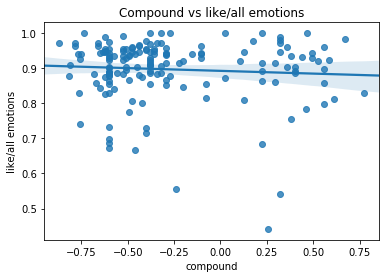

In [11]:
cl1 = sns.regplot(x=data['compound'][data['compound']!=0], y=data['like_ratio1'][data['compound']!=0])
cl1.set_title('Compound vs like/all emotions')
cl1.set_ylabel('like/all emotions')
plt.show(cl1)

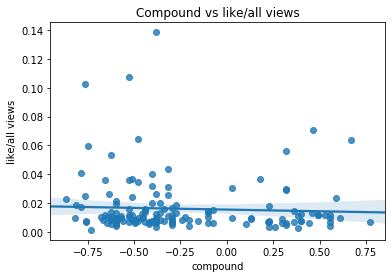

In [12]:
cl2 = sns.regplot(x=data['compound'][data['compound']!=0], y=data['like_ratio2'][data['compound']!=0])
cl2.set_title('Compound vs like/all views')
cl2.set_ylabel('like/all views')
plt.show(cl2)

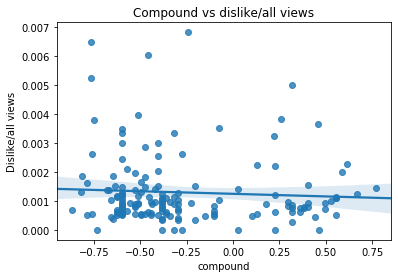

In [13]:
cl3 = sns.regplot(x=data['compound'][data['compound']!=0], y=data['like_ratio3'][data['compound']!=0])
cl3.set_title('Compound vs dislike/all views')
cl3.set_ylabel('Dislike/all views')
plt.show(cl3)

Likes and dislikes might be uncorrelated with the compound.


We then look into some titles of videos with positive or negative sentiments.

In [14]:
print("\"Positive\" headlines:\n")
print(list(data[data['label'] == 1].title)[:5])

print("\nNegative headlines:\n")
print(list(data[data['label'] == -1].title)[:5])

"Positive" headlines:

['Watch live: D.C. mayor updates on coronavirus after first positive case', 'Is Italy’s Massive Coronavirus Quarantine Sign Of Things To Come? | AM Joy | MSNBC', '21 people aboard Grand Princess cruise ship test positive for coronavirus: Pence | ABC News', 'ABC News Prime: Coronavirus global spread, Grand Princess cruise ship, Market meltdown', 'Trump Praises Coronavirus Response As Cases Rack Up And Markets Spiral | The 11th Hour | MSNBC']

Negative headlines:

['Coronavirus death toll rises in Italy to 366 as quarter of population on lockdown | ITV News', 'Coronavirus Threat: To The Economy, And The Presidency | The Day That Was | MSNBC', 'First UK Coronavirus death in Berkshire - BBC NEWS', "Italy's coronavirus outbreak sparks 'a lot of panic", 'At least 12 dead, 188 infected in US as coronavirus continues to spread | Nightline']


Negative headlines approximately had the right sentimental classification, but the positive headlines are not. “Positive” diagnosis of COVID-19 was count as positive sentiment and caused biases. It is possible to check how many titles are affected.


In [15]:
data[data['title'].str.contains('positive', case=False)]['title'].values

array(['Watch live: D.C. mayor updates on coronavirus after first positive case',
       '21 people aboard Grand Princess cruise ship test positive for coronavirus: Pence | ABC News',
       'Coronavirus: Half of California cruise passengers test positive | Nine News Australia',
       'He tested positive for coronavirus.  Hear how he feels now',
       "Coronavirus: Iran's deputy health minister tests positive as outbreak worsens - BBC News"],
      dtype=object)

All observations subsetted matched the situation described above. Then we filter out these observations to see titles of somewhat "positive" sentiments.

In [16]:
data[data['title'].str.contains('positive', case=False) == False][data['label'] == 1]['title'].values

array(['Is Italy’s Massive Coronavirus Quarantine Sign Of Things To Come? | AM Joy | MSNBC',
       'ABC News Prime: Coronavirus global spread, Grand Princess cruise ship, Market meltdown',
       'Trump Praises Coronavirus Response As Cases Rack Up And Markets Spiral | The 11th Hour | MSNBC',
       'Coronavirus outbreak claims lives of more than a dozen Life Care Center residents',
       "Coronavirus: Countries need to 'help each other' as deaths increase - BBC Newsnight",
       'Coronavirus: doctors and nurses in Iran filmed dancing in bid to boost morale',
       'Coronavirus whistleblower doctor is online hero in China',
       'Coronavirus: Worst-hit countries boost containment efforts - BBC News',
       'What is the coronavirus? Everything you need to know about symptoms, how to stay safe and what next',
       'China को मिल गयी Coronavirus की Medicine ?  | Tez Special Report',
       'Coronavirus prevention: how to make your own hand sanitizer',
       'NOVEL CORONAVIRUS(201

We want to ignore some data points with other language that our team does not know.\
Good news do not necessarily have good sentiments revealed in the title. The titles are mostly providing information hence they are usually neutural.\
The NLP sentiment tools included in the package might not be helpful here. The dictionary needs to be trained in the context of outbreak of coronavirus.

## Answer and analysis: 

 


=====================================================================================================================


=====================================================================================================================
# Question 6. Can we separate all videos into different types? 

## - Question Description: 

xxxxxxxx

## - Model:
xxxxxxxx


In [17]:
df

,title,view,channel,uploadtime,length,link,subscriber,like,dislike,clean_text,neg,neu,pos,compound,label,like_ratio1,like_ratio2,like_ratio3
0,Unprecedented restrictions in Italy over coron...,22000,CNN,3,498,https://www.youtube.com/watch?v=v_vDjR5zBDk,8710000,735,124,unprecedented restriction italy coronavirus ou...,0.000,1.000,0.000,0.0000,0,0.855646,0.033409,0.005636
1,New York reels with largest coronavirus outbre...,264000,ABC News,11,237,https://www.youtube.com/watch?v=7JedXOgOPC8,7860000,2082,223,new york reel largest coronavirus outbreak u wnt,0.000,1.000,0.000,0.0000,0,0.903254,0.007886,0.000845
2,Trump urges calm at coronavirus task force bri...,442000,CBS News,10,351,https://www.youtube.com/watch?v=zSfbAP3emSE,2390000,2610,2208,trump urge calm coronavirus task force briefing,0.000,0.753,0.247,0.3182,0,0.541719,0.005905,0.004995
3,Governor Cuomo Gives Updates On Coronavirus In...,98000,MSNBC,14,336,https://www.youtube.com/watch?v=06Q1CQd33zM,2420000,711,253,governor cuomo give update coronavirus new yor...,0.000,1.000,0.000,0.0000,0,0.737552,0.007255,0.002582
4,Coronavirus: Cruise Ship Carrying People With ...,209000,NBC News,10,814,https://www.youtube.com/watch?v=sku3zWvLXnM,1960000,919,101,coronavirus cruise ship carrying people corona...,0.000,1.000,0.000,0.0000,0,0.900980,0.004397,0.000483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,How To Avoid Getting Infected By The Coronavirus,401000,Peak Prosperity,72,144660,https://www.youtube.com/watch?v=4InhmRCIpow,285000,14376,416,avoid getting infected coronavirus,0.474,0.526,0.000,-0.6597,-1,0.971877,0.035850,0.001037
361,Coronavirus: Is the Puzzling Silence From Offi...,412000,Peak Prosperity,504,142440,https://www.youtube.com/watch?v=ReMCn4GsviM,285000,11960,346,coronavirus puzzling silence official calm storm,0.000,0.827,0.173,0.3182,0,0.971884,0.029029,0.000840
362,The CDC has REALLY dropped the ball... [Corona...,4100,The Right Media,48,500,https://www.youtube.com/watch?v=4jJTGdZiNdQ,45000,666,21,cdc really dropped ball coronavirus nd wave truth,0.000,1.000,0.000,0.0000,0,0.969432,0.162439,0.005122
363,Anonymous Urges World Leaders To Tell The Trut...,60000,Anonymous,120,487,https://www.youtube.com/watch?v=86fLmiAvTBU,47600,1773,36,anonymous urge world leader tell truth coronav...,0.000,0.796,0.204,0.3182,0,0.980100,0.029550,0.000600


In [35]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['clean_text'].copy().values)

In [48]:
true_k = 4
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=4, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [49]:
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
feature_name = vectorizer.get_feature_names()

In [50]:
for i in range(true_k):
    print('Cluster %d:' % i),
    for j in order_centroids[i, :10]:
        print('%s' % feature_name[j])

Cluster 0:
doctor
cdc
coronavirus
latest
answer
explains
abc
question
warning
china
Cluster 1:
covid
coronavirus
disease
virus
corona
qa
expert
video
outbreak
deutschland
Cluster 2:
global
march
coronavirus
coverage
world
rise
emergency
prime
effort
case
Cluster 3:
coronavirus
outbreak
news
china
italy
case
trump
death
bbc
wuhan


In [51]:
ver = pd.read_csv('video_clean2.csv', index_col = 0)
ver = ver[ver['uploadtime']<24].copy()

In [52]:
print('\n')
print('Prediction')
YY = vectorizer.transform(ver['clean_text'].copy().values)
predicted = model.predict(YY)
ver['pred'] = predicted
ver[['title','pred','uploadtime']]



Prediction


,title,pred,uploadtime
0,Europe becomes new coronavirus epicenter,3,8
1,WATCH LIVE: Trump gives coronavirus update,3,1
2,Infection Rate Charts Forecast Steep Rise In U...,3,15
3,Iran is building a massive grave for coronavir...,3,22
4,Trump declares national emergency to combat co...,3,22
5,Miami mayor who tested positive for coronaviru...,3,18
6,Coronavirus: Europe at the epicentre of the pa...,3,22
10,What happens if the homeless population gets i...,3,19
28,Coronavirus outbreak: B.C. health officials co...,1,22
31,Coronavirus: What Powers The Government Can Us...,3,21


## Answer and analysis: 

 


=====================================================================================================================
